In [1]:
pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/dubeysachin752/customer-curn/main/train.csv')
test=pd.read_csv('https://raw.githubusercontent.com/dubeysachin752/customer-curn/main/test.csv')
sample=pd.read_csv('https://raw.githubusercontent.com/dubeysachin752/customer-curn/main/test.csv')

In [4]:
train.head()

,ID,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE,PURCHASE
0,1,Uttar Pradesh,28,,Low,2018,No,4937,No
1,2,Madhya Pradesh,27,Salaried,Low,2018,No,10834,No
2,3,West Bengal,62,,High,2013,NaN,8610,Yes
3,4,Tamil Nadu,27,Salaried,Low,2018,No,14374,Yes
4,5,Uttar Pradesh,40,Self employed,High,2015,No,13158,No


In [5]:
train.describe()

,ID,AGE,CUSTOMER_SINCE,PAST_PURCHASE
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,43.805660,2015.507960,11244.207287
std,43301.414527,14.828219,2.685645,8458.166886
min,1.000000,23.000000,2008.000000,208.000000
25%,37500.750000,30.000000,2013.000000,6034.750000
50%,75000.500000,43.000000,2017.000000,8926.000000
75%,112500.250000,54.000000,2018.000000,13636.000000
max,150000.000000,85.000000,2019.000000,103520.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               150000 non-null  int64 
 1   STATE            150000 non-null  object
 2   AGE              150000 non-null  int64 
 3   OCCUPATION       150000 non-null  object
 4   INCOME_GROUP     150000 non-null  object
 5   CUSTOMER_SINCE   150000 non-null  int64 
 6   LOYALTY_PROGRAM  132176 non-null  object
 7   PAST_PURCHASE    150000 non-null  int64 
 8   PURCHASE         150000 non-null  object
dtypes: int64(4), object(5)
memory usage: 10.3+ MB


In [7]:
train.nunique()

ID                 150000
STATE                  34
AGE                    63
OCCUPATION              4
INCOME_GROUP            4
CUSTOMER_SINCE         12
LOYALTY_PROGRAM         2
PAST_PURCHASE       28047
PURCHASE                2
dtype: int64

In [8]:
train.isna().sum()

ID                     0
STATE                  0
AGE                    0
OCCUPATION             0
INCOME_GROUP           0
CUSTOMER_SINCE         0
LOYALTY_PROGRAM    17824
PAST_PURCHASE          0
PURCHASE               0
dtype: int64

In [9]:
train['LOYALTY_PROGRAM'].unique()

array(['No', nan, 'Yes'], dtype=object)

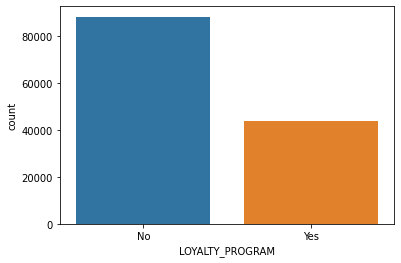

In [10]:
sns.countplot(train['LOYALTY_PROGRAM'])

In [11]:
most_freq = train['LOYALTY_PROGRAM'].mode()[0]     #dealling with null values
#print(most_freq)

train['LOYALTY_PROGRAM'] = train['LOYALTY_PROGRAM'].fillna(most_freq)
test['LOYALTY_PROGRAM'] = test['LOYALTY_PROGRAM'].fillna(most_freq)

In [12]:
train['STATE'].unique()

array(['Uttar Pradesh', 'Madhya Pradesh', 'West Bengal', 'Tamil Nadu',
       'Maharashtra', 'Kerala', 'Goa', 'Karnataka', 'Andhra Pradesh',
       'Telangana', 'Chandigarh', 'Nagaland',
       'Andaman and Nicobar Islands', 'Tripura', 'Delhi',
       'Himachal Pradesh', ' ', 'Puducherry', 'Sikkim', 'Gujarat',
       'Odisha', 'Bihar', 'Punjab', 'Arunachal Pradesh', 'Haryana',
       'Rajasthan', 'Uttarakhand', 'Jammu and Kashmir', 'Assam',
       'Manipur', 'Mizoram', 'Jharkhand', 'Chhattisgarh', 'Meghalaya'],
      dtype=object)

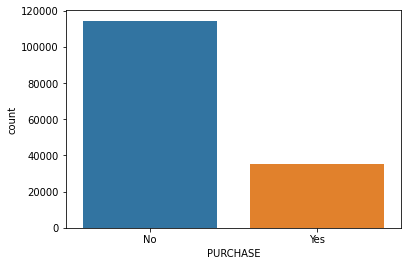

In [13]:
## Find out max purchase state from our training dataset
sns.countplot(x = 'PURCHASE',data=train,
             order = train['PURCHASE'].value_counts().index)

__So can see that data is slightly imbalance might be we have to use class sampling techniques to balance data__

In [14]:
train.drop('ID',axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)

__Which Income Group having max past purchase__ \
1. Low Income people having max purchase

In [15]:
train['INCOME_GROUP'].value_counts()

Low       63523
High      41808
Medium    41232
           3437
Name: INCOME_GROUP, dtype: int64

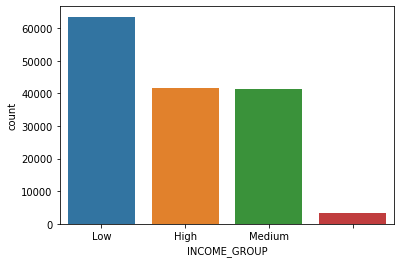

In [16]:
sns.countplot(train['INCOME_GROUP'])

In [17]:
income_grp_purchase = train.groupby(['INCOME_GROUP'])[['PAST_PURCHASE']].sum().reset_index()

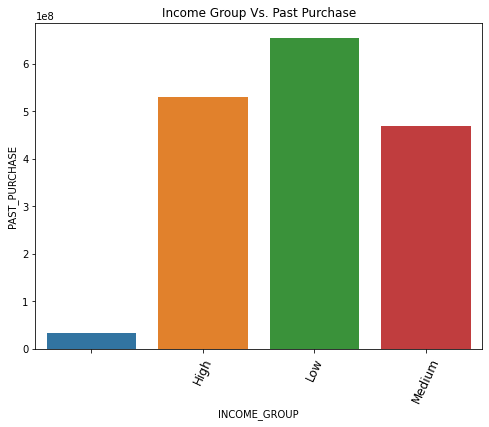

In [18]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=65,fontsize=12)
plt.xlabel("Income Group")
plt.ylabel("Past Purchase")
plt.title("Income Group Vs. Past Purchase")
sns.barplot('INCOME_GROUP', 'PAST_PURCHASE', data=income_grp_purchase);
plt.show()

__Which Group People having max past purchase__ \
1. Self Employed people having past max purchase

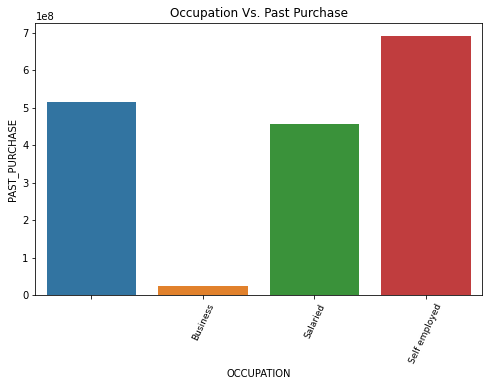

In [19]:
occupation_max_past_pur = train.groupby(['OCCUPATION'])[['PAST_PURCHASE']].sum().reset_index()
plt.figure(figsize=(8,5))
plt.xticks(rotation=65,fontsize=9)
plt.xlabel("Occupation")
plt.ylabel("Past Purchase")
plt.title("Occupation Vs. Past Purchase")
sns.barplot('OCCUPATION', 'PAST_PURCHASE', data=occupation_max_past_pur);
plt.show()

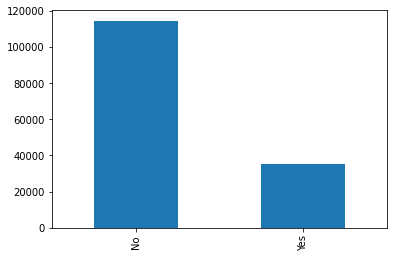

In [20]:
train['PURCHASE'].value_counts().plot.bar()

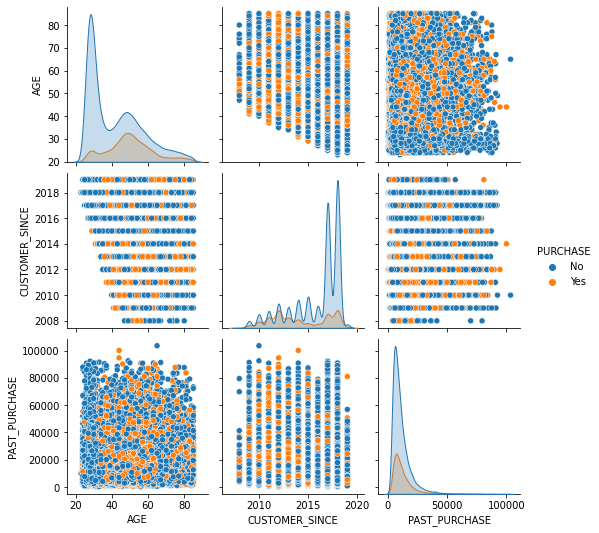

In [21]:
sns.pairplot(train,hue='PURCHASE')

1. 20-30 years people purchase mostly.
2. Very small amount of people purchasing the same item again

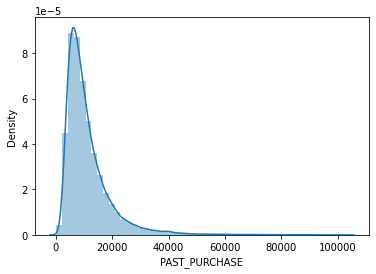

In [22]:
sns.distplot(train['PAST_PURCHASE'])

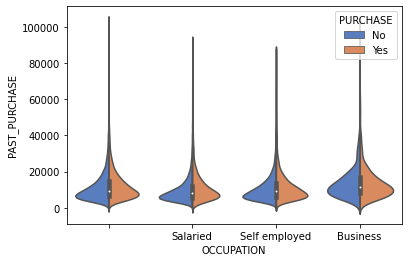

In [23]:
sns.violinplot(x='OCCUPATION',y="PAST_PURCHASE", hue="PURCHASE",
            data=train, palette="muted", split=True)

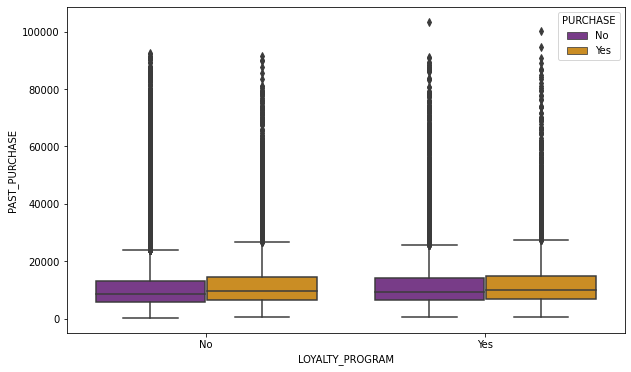

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x='LOYALTY_PROGRAM',y="PAST_PURCHASE", hue="PURCHASE",
            data=train, palette="CMRmap")

__can see to many outliers in PAST_PURCHASE so have to remove it for it let's check distribution for it__

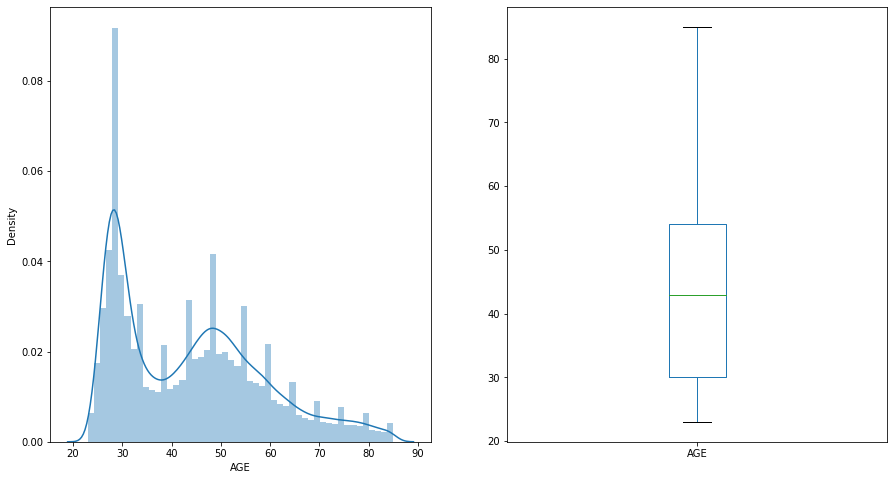

In [25]:
plt.subplot(121)
sns.distplot(train['AGE'])

plt.subplot(122)
train['AGE'].plot.box(figsize=(15,8))
plt.show()



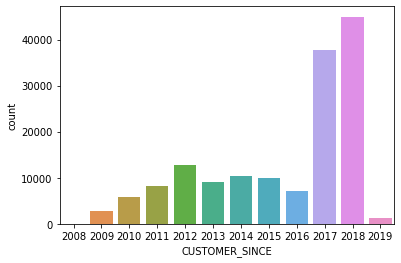

In [26]:
sns.countplot(train['CUSTOMER_SINCE'])

In [28]:
train['OCCUPATION'].unique() ,test['OCCUPATION'].unique()

(array([' ', 'Salaried', 'Self employed', 'Business'], dtype=object),
 array(['Self employed', 'Salaried', ' ', 'Business'], dtype=object))

In [29]:
train['PURCHASE'].replace('No',0,inplace =True)
train['PURCHASE'].replace('Yes',1,inplace =True)



In [30]:
train.head()

,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE,PURCHASE
0,Uttar Pradesh,28,,Low,2018,No,4937,0
1,Madhya Pradesh,27,Salaried,Low,2018,No,10834,0
2,West Bengal,62,,High,2013,No,8610,1
3,Tamil Nadu,27,Salaried,Low,2018,No,14374,1
4,Uttar Pradesh,40,Self employed,High,2015,No,13158,0


In [31]:
train['OCCUPATION'].replace(' ','Other',inplace =True)
test['OCCUPATION'].replace(' ','Other',inplace =True)

In [ ]:
#cols=['CUSTOMER_SINCE']

#train = pd.get_dummies(train,columns=cols)
#test = pd.get_dummies(test,columns=cols)

In [32]:
train['CUSTOMER_SINCE'].unique()

array([2018, 2013, 2015, 2010, 2014, 2019, 2017, 2016, 2011, 2012, 2009,
       2008])

In [33]:
train['CUSTOMER_SINCE'].replace(2008,1,inplace =True)
train['CUSTOMER_SINCE'].replace(2009,2,inplace =True)
train['CUSTOMER_SINCE'].replace(2010,3,inplace =True)
train['CUSTOMER_SINCE'].replace(2011,4,inplace =True)
train['CUSTOMER_SINCE'].replace(2012,5,inplace =True)
train['CUSTOMER_SINCE'].replace(2013,6,inplace =True)
train['CUSTOMER_SINCE'].replace(2014,7,inplace =True)
train['CUSTOMER_SINCE'].replace(2015,8,inplace =True)
train['CUSTOMER_SINCE'].replace(2016,9,inplace =True)
train['CUSTOMER_SINCE'].replace(2017,10,inplace =True)
train['CUSTOMER_SINCE'].replace(2018,11,inplace =True)
train['CUSTOMER_SINCE'].replace(2019,12,inplace =True)



test['CUSTOMER_SINCE'].replace(2008,1,inplace =True)
test['CUSTOMER_SINCE'].replace(2009,2,inplace =True)
test['CUSTOMER_SINCE'].replace(2010,3,inplace =True)
test['CUSTOMER_SINCE'].replace(2011,4,inplace =True)
test['CUSTOMER_SINCE'].replace(2012,5,inplace =True)
test['CUSTOMER_SINCE'].replace(2013,6,inplace =True)
test['CUSTOMER_SINCE'].replace(2014,7,inplace =True)
test['CUSTOMER_SINCE'].replace(2015,8,inplace =True)
test['CUSTOMER_SINCE'].replace(2016,9,inplace =True)
test['CUSTOMER_SINCE'].replace(2017,10,inplace =True)
test['CUSTOMER_SINCE'].replace(2018,11,inplace =True)
test['CUSTOMER_SINCE'].replace(2019,12,inplace =True)

In [34]:
train.head()

,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE,PURCHASE
0,Uttar Pradesh,28,Other,Low,11,No,4937,0
1,Madhya Pradesh,27,Salaried,Low,11,No,10834,0
2,West Bengal,62,Other,High,6,No,8610,1
3,Tamil Nadu,27,Salaried,Low,11,No,14374,1
4,Uttar Pradesh,40,Self employed,High,8,No,13158,0


In [35]:
from sklearn import preprocessing 

cat_columns = []
for col in train.select_dtypes('object').columns:
    print(col)
    cat_columns.append(col)
    le = preprocessing.LabelEncoder()
    train[col] = le.fit_transform(train[col])

STATE
OCCUPATION
INCOME_GROUP
LOYALTY_PROGRAM


In [36]:
cat_columns = []
for col in test.select_dtypes('object').columns:
    #print(col)
    cat_columns.append(col)
    le = preprocessing.LabelEncoder()
    test[col] = le.fit_transform(test[col])

In [37]:
train.dtypes

STATE              int64
AGE                int64
OCCUPATION         int64
INCOME_GROUP       int64
CUSTOMER_SINCE     int64
LOYALTY_PROGRAM    int64
PAST_PURCHASE      int64
PURCHASE           int64
dtype: object

In [38]:
X=train.drop('PURCHASE',1)
y=train['PURCHASE']

Model Building


In [39]:
from sklearn.model_selection import train_test_split
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=150303,stratify=y,shuffle=True)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score

In [41]:
model=LogisticRegression()          #model_1 logistic regsn
model.fit(X_train,y_train)
pred_logistics=model.predict(X_valid)

In [42]:
f1_score(y_valid,pred_logistics),


(0.1352132208482607,)

In [43]:
roc_auc_score(y_valid,pred_logistics)

0.5199561358415322

In [44]:
from xgboost import XGBClassifier     #model_2 XGBoost

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
pred_xgb=xgb.predict(X_valid)
f1_score(y_valid,pred_xgb)

0.2720605088242035

In [47]:
from sklearn.ensemble import RandomForestClassifier      #model_3 XGBoost

rand_forst=RandomForestClassifier()
rand_forst.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
pred_rand=rand_forst.predict(X_valid)
f1_score(y_valid,pred_rand)

0.3739921084234002

In [ ]:
#before tune :0.3739921084234002
#after tunning :

tunning of random forst model

In [49]:
from sklearn.model_selection import GridSearchCV    
Paragrid ={'max_depth':list(range(1,20,5)),
           'n_estimators': list(range(1,200,50))}
grid_search =GridSearchCV(RandomForestClassifier(random_state =1),Paragrid)

In [50]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                

In [51]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [53]:
rand_forst_tune=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
rand_forst_tune.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [54]:
pred_rand_tune=rand_forst_tune.predict(X_valid)
f1_score(y_valid,pred_rand_tune)

0.2866809518439157

In [55]:
cat_col=['STATE','OCCUPATION','INCOME_GROUP','LOYALTY_PROGRAM' ]

In [56]:
from catboost import CatBoostClassifier        #model_4 XGBoost
catb = CatBoostClassifier()
catb= catb.fit(X_train, y_train,cat_features=cat_col,eval_set=(X_valid, y_valid),early_stopping_rounds=30,verbose=100)
y_pred = catb.predict(X_valid)
proba = catb.predict(X_valid)
print('CatBoost Base Accuracy : {}'.format(accuracy_score(y_valid,y_pred)))
print('CatBoost Base f1_score: {}'.format(f1_score(y_valid,proba)))
print('CatBoost Base roc_auc_score: {}'.format(roc_auc_score(y_valid,proba)))

Learning rate set to 0.103387
0:	learn: 0.6382144	test: 0.6381239	best: 0.6381239 (0)	total: 204ms	remaining: 3m 23s
100:	learn: 0.4439209	test: 0.4472451	best: 0.4472378 (99)	total: 12s	remaining: 1m 46s
200:	learn: 0.4401622	test: 0.4465278	best: 0.4465278 (200)	total: 24s	remaining: 1m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4465270765
bestIteration = 201

Shrink model to first 202 iterations.
CatBoost Base Accuracy : 0.7898333333333334
CatBoost Base f1_score: 0.30092027941013416
CatBoost Base roc_auc_score: 0.5832379063355565


In [57]:
model = LGBMClassifier()                #model_5 LGboost
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
proba = model.predict(X_valid)

In [58]:
# Base model metrics 
print('LGBM Base Accuracy : {}'.format(accuracy_score(y_valid,y_pred)))
print('LGBM Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_valid,proba)))
print('LGBM Base f1_SCORE: {}'.format(f1_score(y_valid,proba)))

LGBM Base Accuracy : 0.7891333333333334
LGBM Base ROC_AUC_SCORE: 0.5828281958117866
LGBM Base f1_SCORE: 0.3003760230037602


##model tunning

In [60]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=0
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    proba = model.predict(X_valid)
    score = roc_auc_score(y_valid,proba)
    return score

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)
proba = lgb.predict(X_valid)
print('Optimized LightGBM roc_auc_score', roc_auc_score(y_valid, proba))


[I 2021-06-06 12:41:15,358] A new study created in memory with name: no-name-2a1e06fe-df56-45f1-bae4-135709d2d698
[I 2021-06-06 12:41:30,110] Trial 0 finished with value: 0.6043048910258142 and parameters: {'max_depth': 17, 'n_estimators': 358, 'learning_rate': 0.6027634157953062, 'num_leaves': 2725, 'min_child_samples': 86, 'reg_alpha': 7, 'reg_lambda': 5}. Best is trial 0 with value: 0.6043048910258142.
[I 2021-06-06 12:41:56,755] Trial 1 finished with value: 0.6069148842181183 and parameters: {'max_depth': 27, 'n_estimators': 482, 'learning_rate': 0.38344158048162585, 'num_leaves': 3959, 'min_child_samples': 107, 'reg_alpha': 6, 'reg_lambda': 10}. Best is trial 1 with value: 0.6069148842181183.
[I 2021-06-06 12:41:57,476] Trial 2 finished with value: 0.5326073988318676 and parameters: {'max_depth': 4, 'n_estimators': 44, 'learning_rate': 0.020218495418485975, 'num_leaves': 4164, 'min_child_samples': 157, 'reg_alpha': 9, 'reg_lambda': 10}. Best is trial 1 with value: 0.60691488421811

Optimized LightGBM roc_auc_score 0.6085973072356745


In [61]:
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.466310826225229,
               max_depth=20, min_child_samples=34, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=127, n_jobs=-1, num_leaves=1223,
               objective=None, random_state=0, reg_alpha=2, reg_lambda=7,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [63]:
LGBM = lgb
LGBM.fit(X, y)
y_pred = LGBM.predict(X_valid)
proba = LGBM.predict(X_valid)


In [64]:
print('LGBM Tuned Accuracy : {}'.format(accuracy_score(y_valid,y_pred)))
print('LGBM Tuned ROC_AUC_SCORE: {}'.format(roc_auc_score(y_valid,proba)))
print('LGBM Tuned F1_SCORE: {}'.format(f1_score(y_valid,proba)))

LGBM Tuned Accuracy : 0.9099666666666667
LGBM Tuned ROC_AUC_SCORE: 0.8278989217528325
LGBM Tuned F1_SCORE: 0.7792759663316172


In [65]:
LGBM_proba = LGBM.predict(test) # Class 1 probability of LGBM model
cat_proba = catb.predict(test) # Class 1 probability of CatBoost model

In [66]:
submit_proba = ((LGBM_proba * 0.45) + (cat_proba * 0.55))/2
sample['PURCHASE'] = submit_proba

In [70]:
for i in sample['PURCHASE']:
  if (i < 0.499) :
    sample['PURCHASE']=0
  else:
    sample['PURCHASE']=1


In [73]:
sample['PURCHASE'].head()

0    No
1    No
2    No
3    No
4    No
Name: PURCHASE, dtype: object

In [72]:

sample['PURCHASE'].replace(0,'No',inplace =True)
sample['PURCHASE'].replace(1,'Yes',inplace =True)

In [75]:
sample.to_csv('sample_submission_by catboost_lgb_mix.csv', index=False)

In [79]:
f_importance = pd.DataFrame(catb.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance = f_importance.sort_values(by='importance', ascending=False)

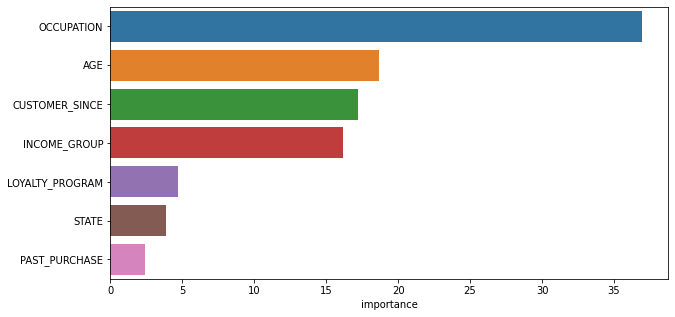

In [80]:
plt.figure(figsize=(10,5))
sns.barplot(x=f_importance.importance[:500], y=f_importance.index[:500]);